In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import os

In [2]:
def show_image(image, cmap=None):
    plt.figure(figsize=(20,10))
    plt.imshow(image, cmap=cmap)
    plt.show() 

In [3]:
def region_of_interest(image, vertices):
    # blank mask
    mask = np.zeros_like(image)   
    
    # 3 or more channels
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        mask_color = (255,) * channel_count
    # 1 channel
    else:
        mask_color = 255
        
    # keep the pixels inside the region defined by vertices   
    # their color = mask_color
    cv2.fillPoly(mask, vertices, mask_color)
    
    # keep only the region of interest
    return cv2.bitwise_and(image, mask)

In [4]:
def weighted_image(initial_image, image, alpha, beta, gamma):
    # res = initial_image * alpha + image * beta + gamma
    return cv2.addWeighted(initial_image, alpha, image, beta, gamma)

In [5]:
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [6]:
def get_slope(line):
    x1, y1, x2, y2 = line
    
    return np.inf if x1 == x2 else (y2-y1)/(x2-x1)

In [7]:
# constructs a new blank image and fills it with the specified lines
def fill_with_lines(lines, image_shape, thickness=5):
    img_lines = np.zeros(image_shape, dtype=np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img_lines, (x1,y1), (x2,y2), (255, 0, 0), thickness)
    
    return img_lines

#### 1. Basic approach: simple lane identification by color selection and region of interest

First step: color selection

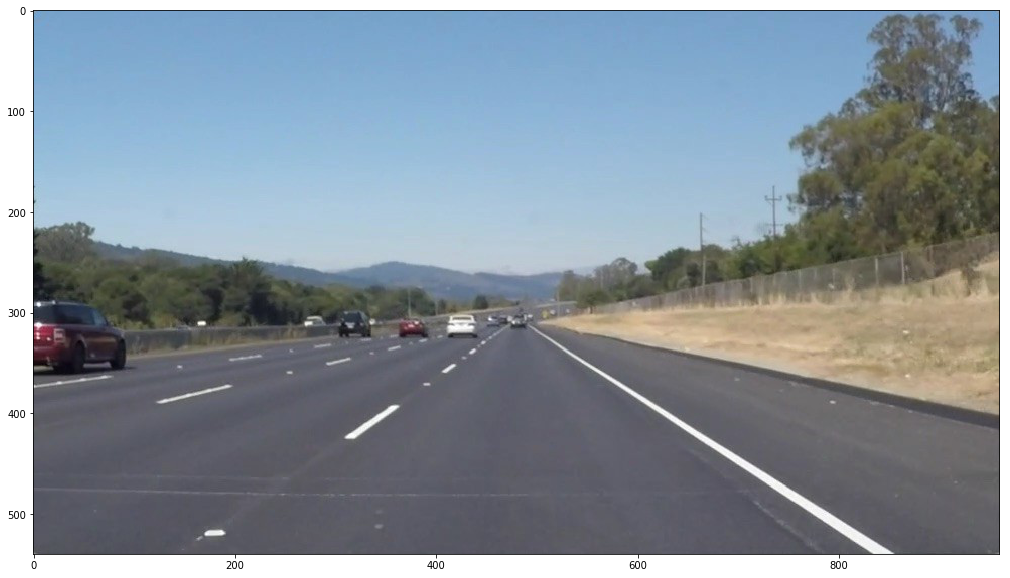

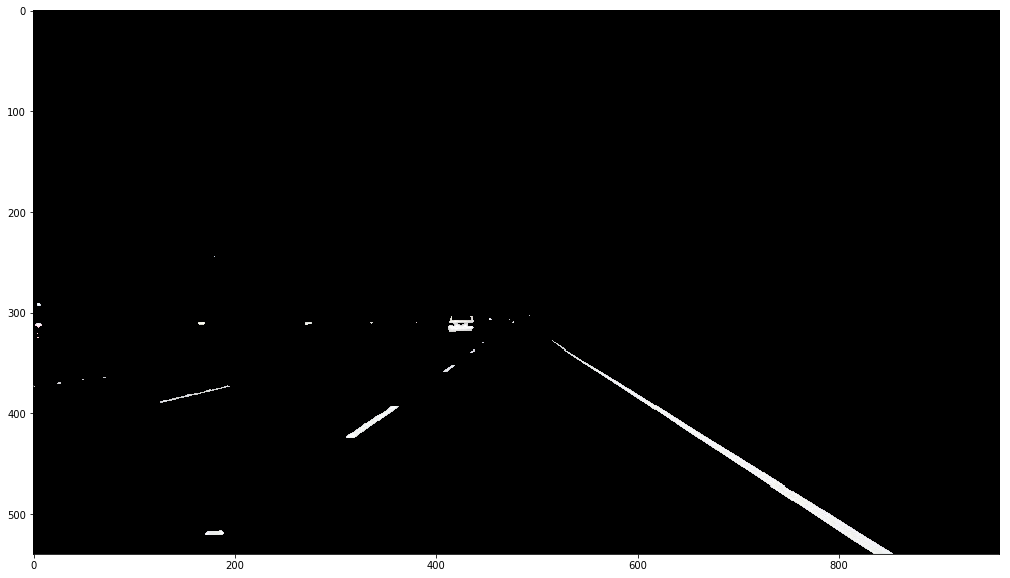

In [10]:
# Read in the image
image = mpimg.imread('./imgs/lanes1.jpeg')

show_image(image)

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]

img_color_select = np.copy(image)

# Define color selection criteria
thr = 195
red_threshold = thr
green_threshold = thr
blue_threshold = thr

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Identify pixels below the thresholds
color_thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
img_color_select[color_thresholds] = [0, 0, 0]

# Display the image   
show_image(img_color_select)


Second step: assume that the camera is mounted in a **fixed** position on the front of the car => we can derive a **region of interest**

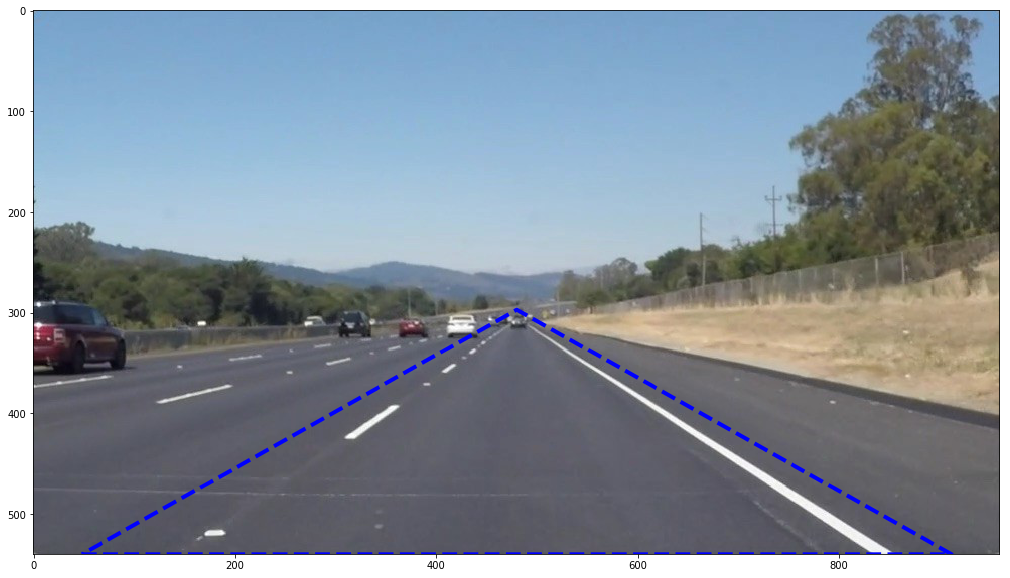

In [11]:
# Define a triangle region of interest 
ybias = 0.05 * ysize
xbias = 0.05 * xsize

apex = [xsize / 2, ysize / 2 + ybias]
left_bottom = [xbias, ysize]
right_bottom = [xsize - xbias, ysize]

# Draw region of interest
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]

plt.figure(figsize=(20,10))
plt.plot(x, y, 'b--', lw=4)
plt.imshow(image)
plt.show()


Combine color selection with region of interest

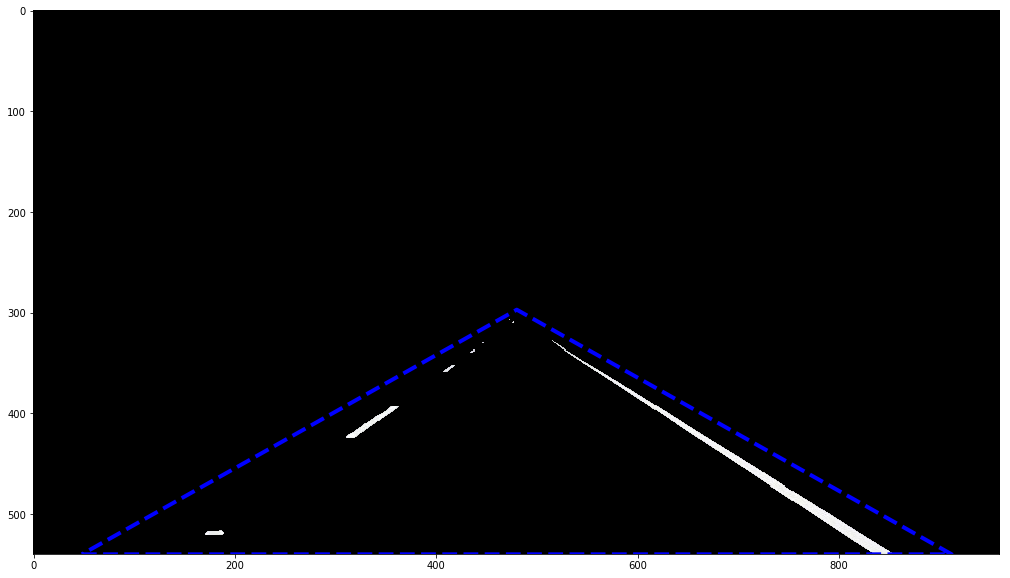

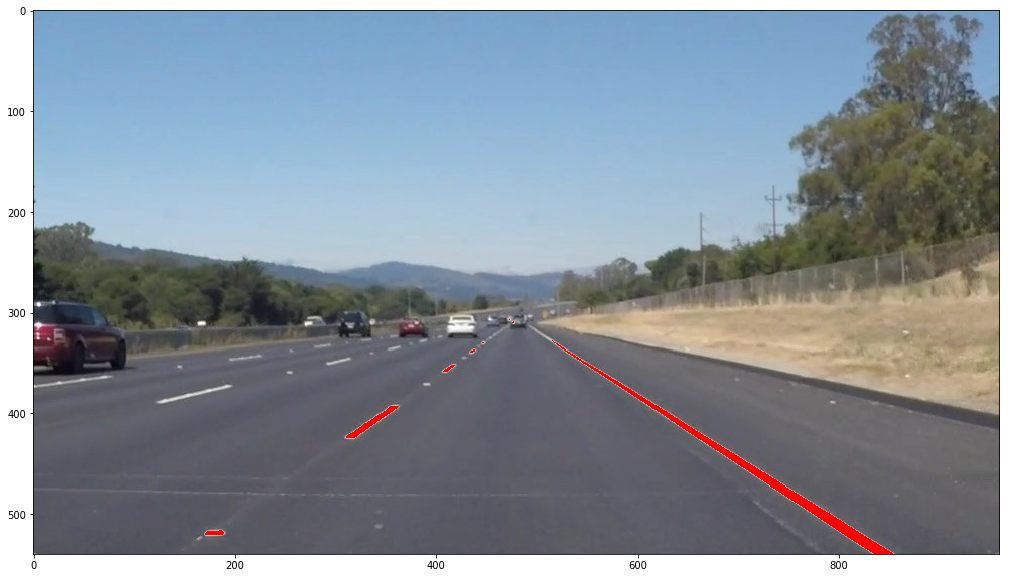

In [12]:
img_color_select = np.copy(image)
img_line_select = np.copy(image)

fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

# Mask color and region selection
img_color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
img_line_select[~color_thresholds & region_thresholds] = [255, 0, 0]


# Draw triangle (region of interest)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.figure(figsize=(20,10))
plt.plot(x, y, 'b--', lw=4)
plt.imshow(img_color_select)
plt.show()

# draw recognized lines in red
plt.figure(figsize=(20,10))
plt.imshow(img_line_select)
plt.show()

#### 2. Better approach: Canny edge detection + Hough-space transform

Canny: identify the boundaries of an object in an image.
- convert to grayscale
- compute the gradient (in _gradient space_, the brightness of a pixel corresponds to the strength of the gradient at that point)
- find edges by tracing the pixels that follow the strongest gradients

`cv2.Canny(image, low_threshold, high_threshold)`

`low_threshold` and `high_threshold` determine how strong the edges must be to be detected (= difference of values of adjacent pixels = strength of the gradient)

Canny keeps strong edge (strong gradient) pixels above the `high_threshold`, and reject pixels below the `low_threshold`. Pixels with values between the `low_threshold` and `high_threshold` will be included as long as they are connected to strong edges. 

edge = rapid change in brightness

Canny gives the individual pixels that follow the strongest gradients.

In [13]:
def canny(image, low, high, gaussian=False):
    if gaussian:
        kernel_size = 5
        image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    
    img_edges = cv2.Canny(image, low, high)
    return img_edges

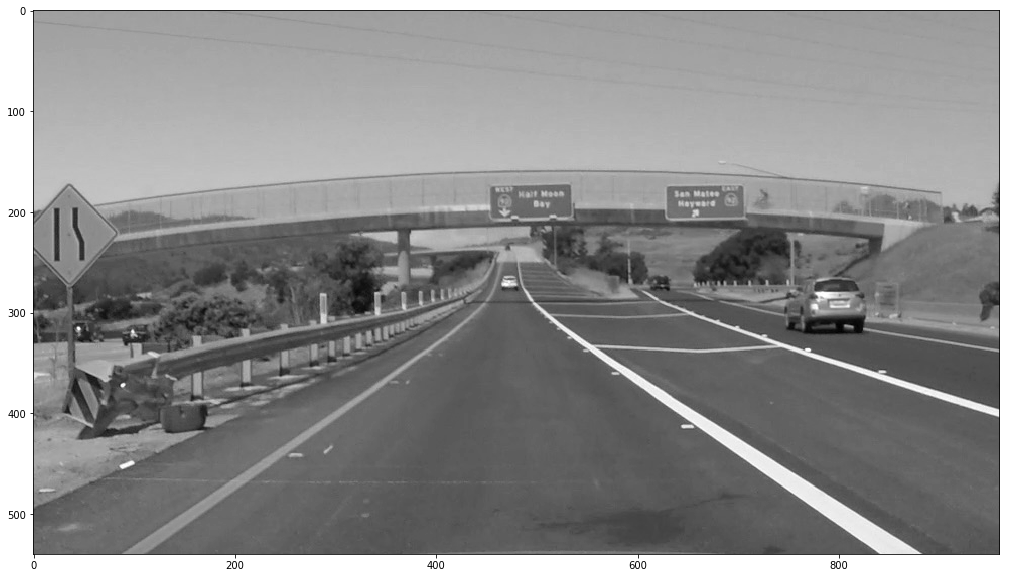

In [15]:
image = cv2.imread("./imgs/exit-ramp.jpg")
img_gray = to_grayscale(image)

show_image(img_gray, 'gray')

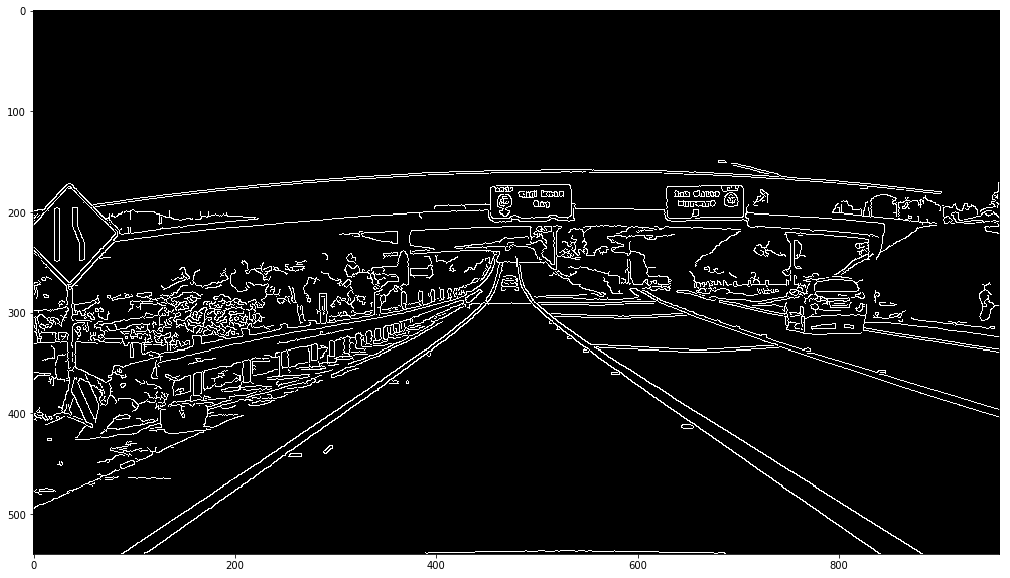

In [16]:
# Without extra gaussian filter
img_edges = canny(img_gray, 50, 150)

show_image(img_edges, 'Greys_r')

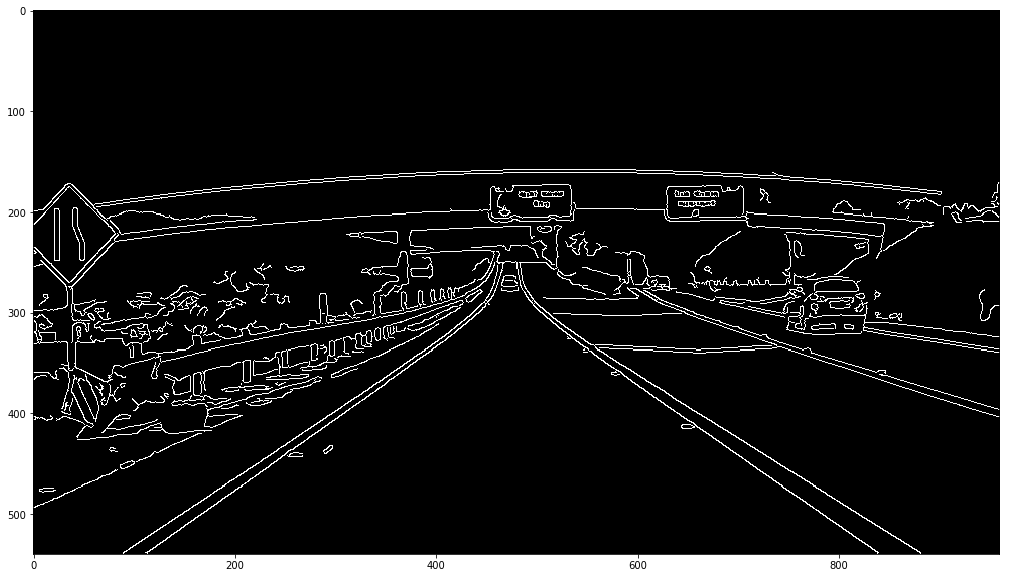

In [17]:
# With extra gaussian filter
img_edges = canny(img_gray, 50, 150, True)

show_image(img_edges, 'Greys_r')

**Hough Space** is parameter space (in our case, $m$ and $b$).

- a line in IS becomes a point in HS: $y = m_0 x + b_0 \rightarrow (m_0, b_0)$
- a point in IS becomes a line in HS: $(x_0, y_0) \rightarrow m = \frac{y_0}{x_0} - \frac{b}{x_0}$

For 2 points $p_1, p_2$ in IS there are 2 **intersecting** lines in HS. The intersection point is at $(m, b)$ that defines the single line that passes through both $p_1$ and $p_2$.

So, the strategy to find lines in IS is to look for intersecting lines in HS. We can consider every point in the `img_edges` as a line in HS and where many lines in HS intersect => found a collection of points that describe a line in IS.

*Problem:* vertical lines have $m = \infty$ => new parameterization.

IS: $\rho_0 = x \cos(\theta_0) + y \sin(\theta_0)$

HS: $(\theta_0, \rho_0)$

Now, each point in IS corresponds to a sine curve in HS. The intersection of the sine curves in HS gives $(\theta_0, \rho_0)$, the paremeterization of the line in IS.

**Grid layout** resolution: $\theta_r$ radians, $\rho_r$ pixels.

In [18]:
# construct trapezoidal region
def construct_region(img_shape):
    [ysize, xsize, _] = img_shape
    
    dx = 0.07 * xsize
    dy = 0.52 * ysize
    gap = 20
    
    p1 = [dx, ysize]
    p2 = [xsize - dx, ysize]
    p3 = [xsize / 2 + gap / 2, dy]
    p4 = [xsize / 2 - gap / 2, dy]
    
    trapezoidal_region = np.array([p1, p2, p3, p4], dtype=np.int32)
    
    return trapezoidal_region

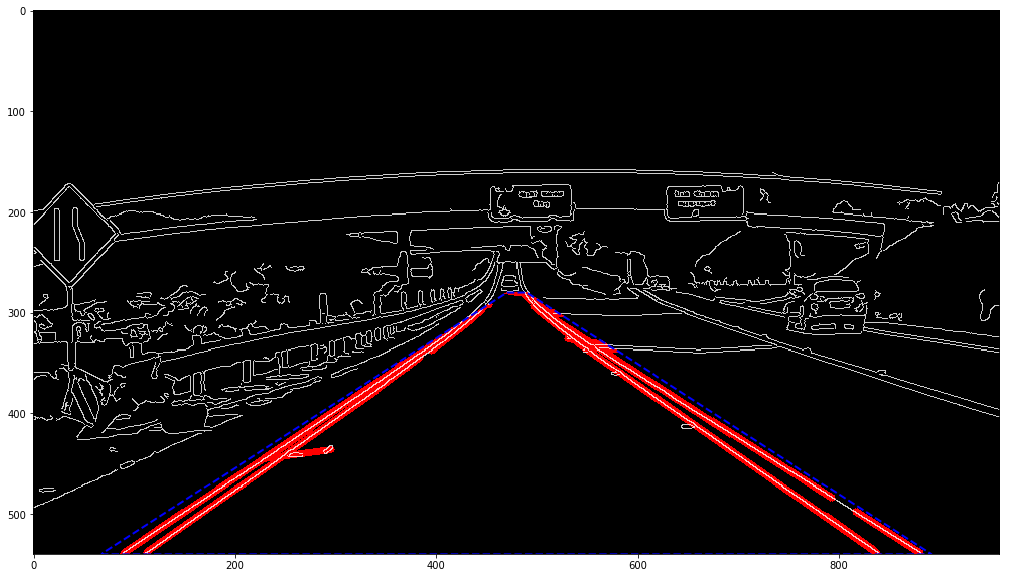

In [19]:
# cv2.HoughLinesP returns an array 
# containing the endpoints (x1, y1, x2, y2) 
# of all line segments detected by the transform operation

# pixels
rho_res = 2
# degrees
theta_res = 1 * np.pi / 180 
# minimum number of votes (intersections in a given grid cell) 
# a candidate line needs to have to make it into the output
threshold = 15
# minimum length of a line (in pixels) that will be accepted in the output
min_line_length = 40
# maximum distance (in pixels) between segments that will be allowed to be connected into a single line
max_line_gap = 20

# create a blank image (same size as original image)
lines = cv2.HoughLinesP(img_edges, rho_res, theta_res, threshold, np.array([]), min_line_length, max_line_gap)

img_lines = fill_with_lines(lines, image.shape)

# construct trapezoidal region
trapezoidal_region = construct_region(image.shape)

color_edges = np.dstack((img_edges,) * 3)

# get only those lines inside the trapezoidal region
constrained_lines = region_of_interest(img_lines, [trapezoidal_region])

# out = 0.8 * color_edges + 1.0 * img_lines + 0
out = weighted_image(color_edges, constrained_lines, 0.8, 1, 0)


plt.figure(figsize=(20,10))

xs = [trapezoidal_region[i][0] for i in np.arange(5) % 4]
ys = [trapezoidal_region[i][1] for i in np.arange(5) % 4]

plt.plot(xs, ys, 'b--', lw=2)

plt.imshow(out)
plt.show()


In [20]:
def detect(image_path, debug=False):
    image = mpimg.imread(image_path)
    img_gray = to_grayscale(image)
    img_edges = canny(img_gray, 125, 200, True)
    
    # parameters
    rho = 2
    theta = 1 * np.pi / 180 
    threshold = 15
    min_line_length = 40
    max_line_gap = 20
    
    lines = cv2.HoughLinesP(img_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    #img_lines = fill_with_lines(lines, image.shape, 2)
    img_lines = np.zeros_like(image)
    s = []
    for line in lines:
        slope = get_slope(line[0])
        
        if slope != np.inf:
            deg = np.abs(slope * 180 / np.pi)
            if 25 <= deg <= 45:
                s.append(slope * 180 / np.pi)
                
                for x1, y1, x2, y2 in line:
                    cv2.line(img_lines, (x1,y1), (x2,y2), (255, 0, 0), 5)
    
    
            

    # construct trapezoidal region
    trapezoidal_region = construct_region(image.shape)

    color_edges = np.dstack((img_edges,) * 3)

    # get only those lines inside the trapezoidal region
    constrained_lines = region_of_interest(img_lines, [trapezoidal_region])

    # out = 0.8 * color_edges + 1.0 * img_lines + 0
    out = weighted_image(image, constrained_lines, 0.8, 1, 0)
    
    plt.figure(figsize=(20,10))
    
    if debug:
        out = weighted_image(color_edges, constrained_lines, 0.8, 1, 0)
        
        xs = [trapezoidal_region[i][0] for i in np.arange(5) % 4]
        ys = [trapezoidal_region[i][1] for i in np.arange(5) % 4]

        plt.plot(xs, ys, 'b--', lw=2)
        
    plt.imshow(out)
    plt.show()

    
    return out, s

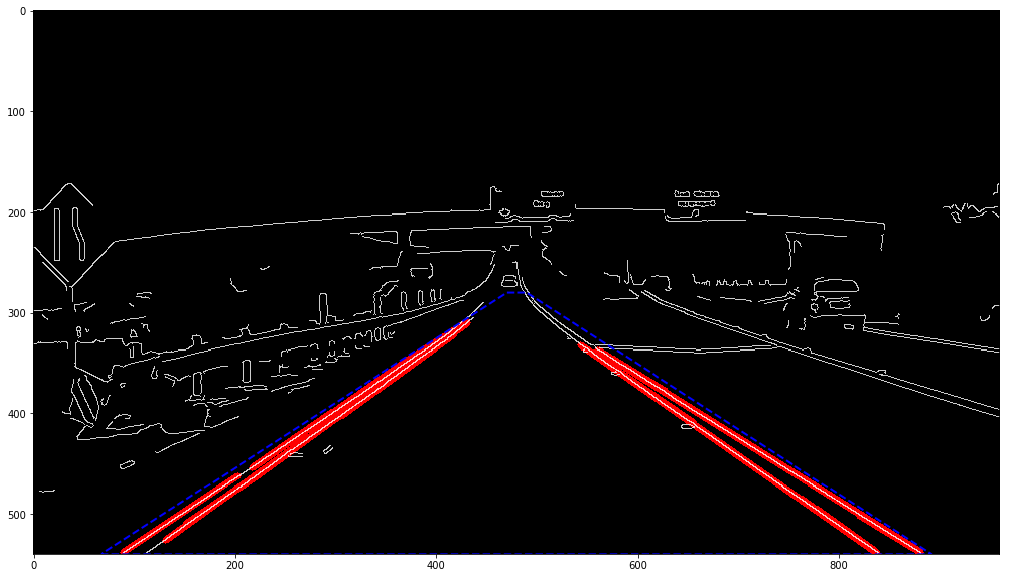

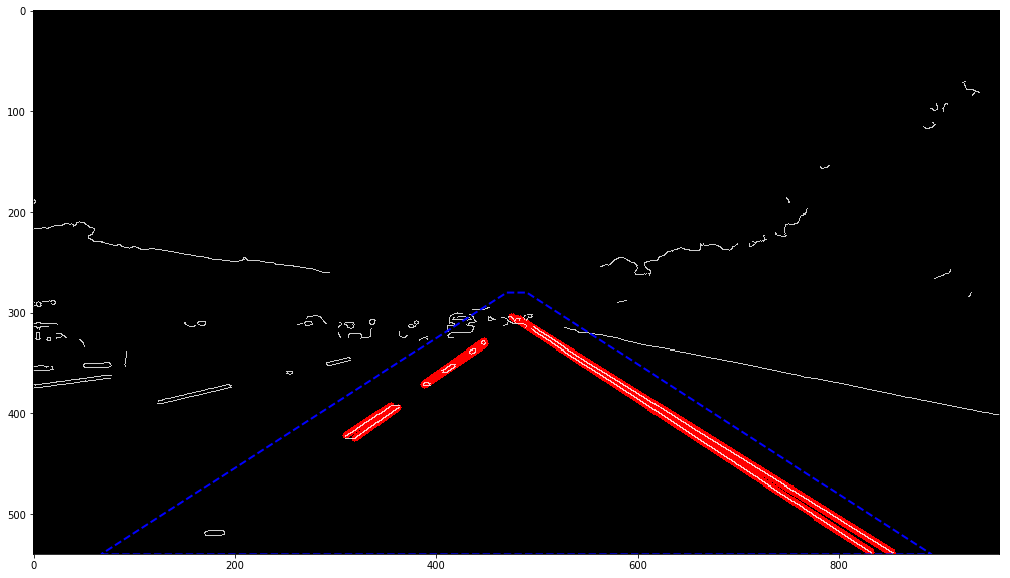

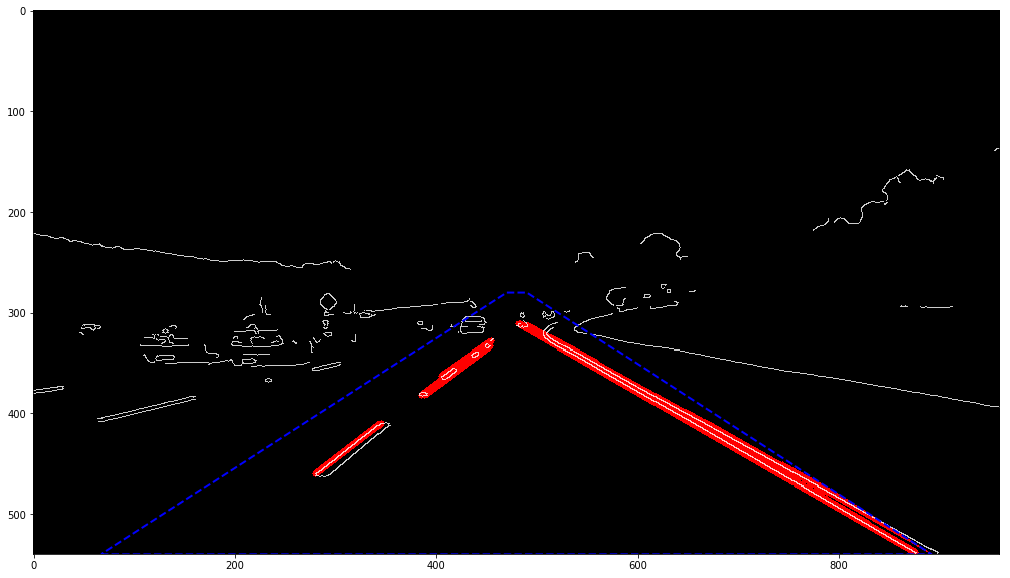

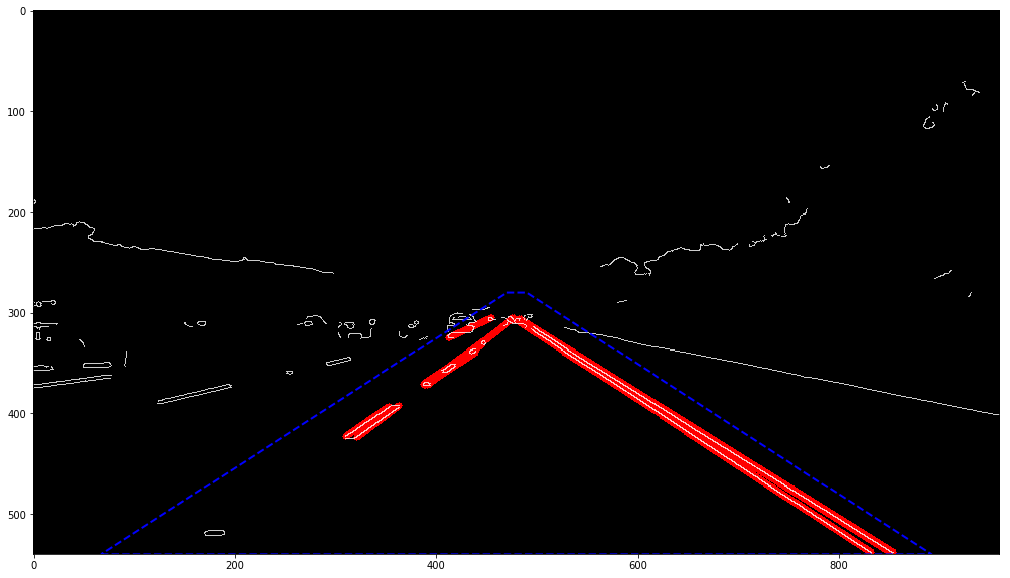

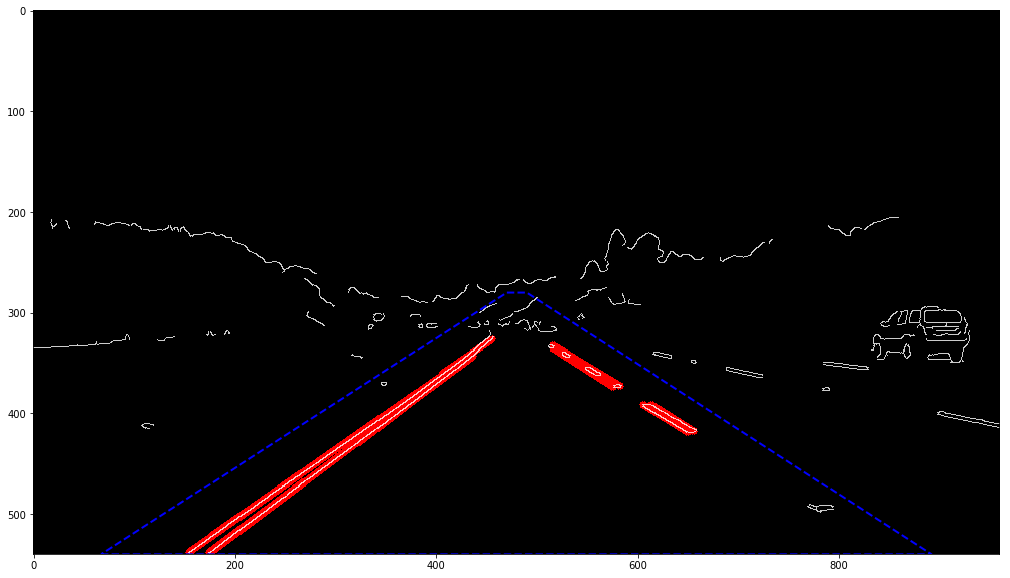

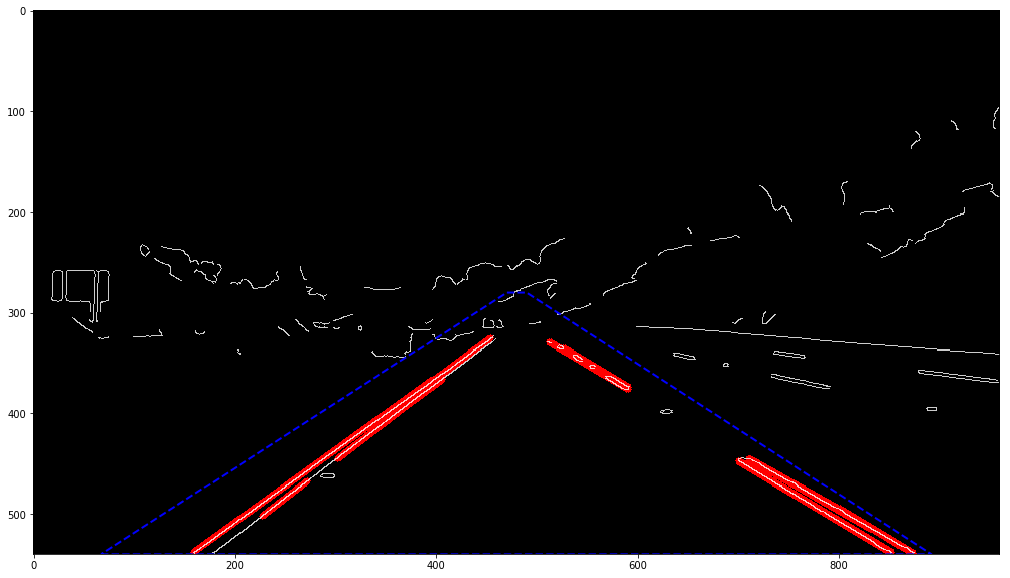

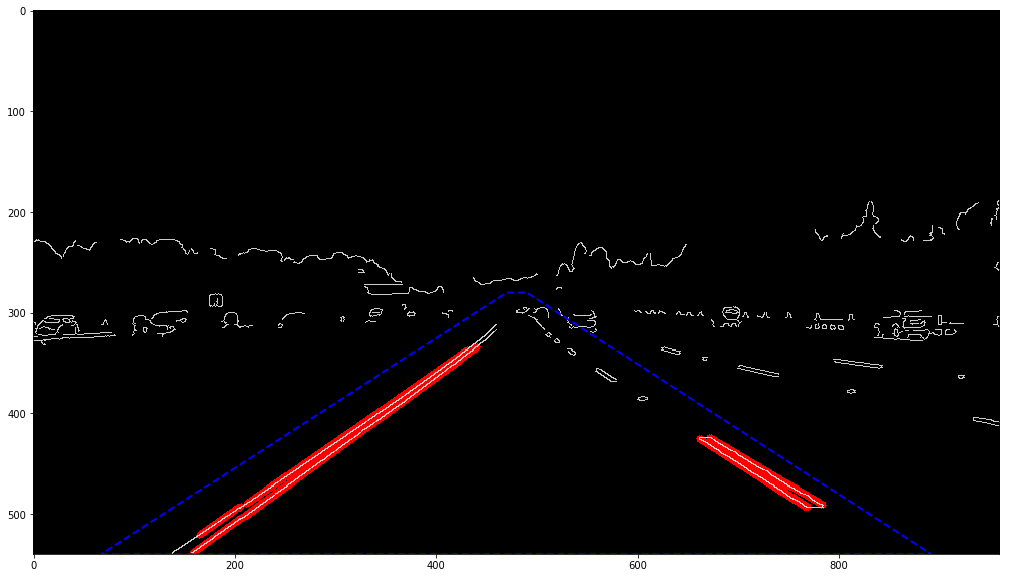

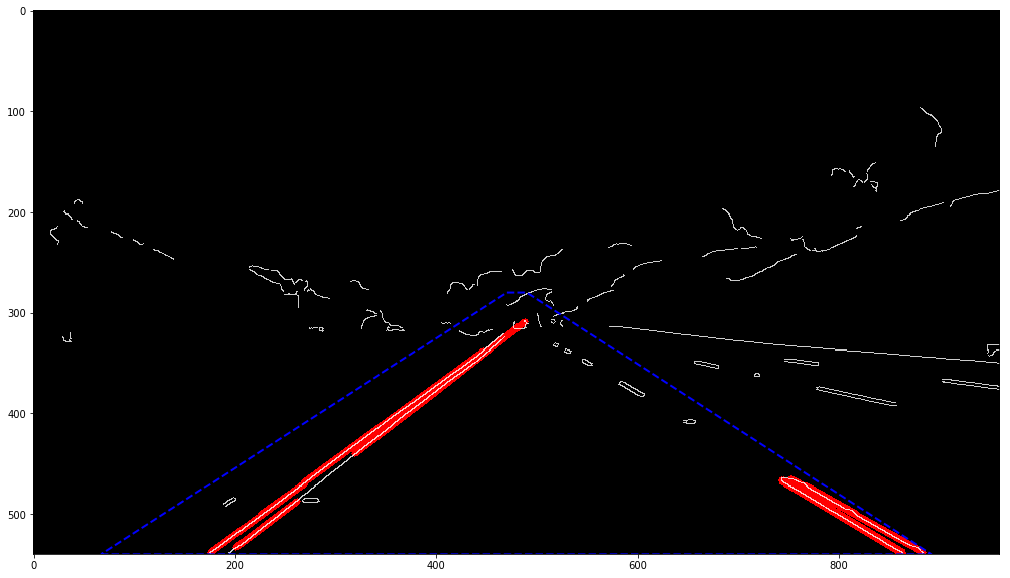

In [22]:
imgs = os.listdir("./imgs")

for img in imgs:
    i, s = detect("./imgs/" + img, True)